In [131]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import seaborn as sns
import scipy
from typing import Tuple

import arviz as az

import pyro
import pyro.contrib.gp as gp
import pyro.distributions as dist
from pyro.infer import NUTS, MCMC

In [2]:
az.style.use("arviz-darkgrid")

In [155]:
def f(x):
    return np.sin(20*x) + 2*np.cos(14*x) - 2*np.sin(6*x)

# dataset
x = torch.tensor([-1.0, -0.5, 0.0, 0.5, 1.0])
y = f(x)

x_ = torch.linspace(-1-0, 1.0, 500)
y_ = f(x_)


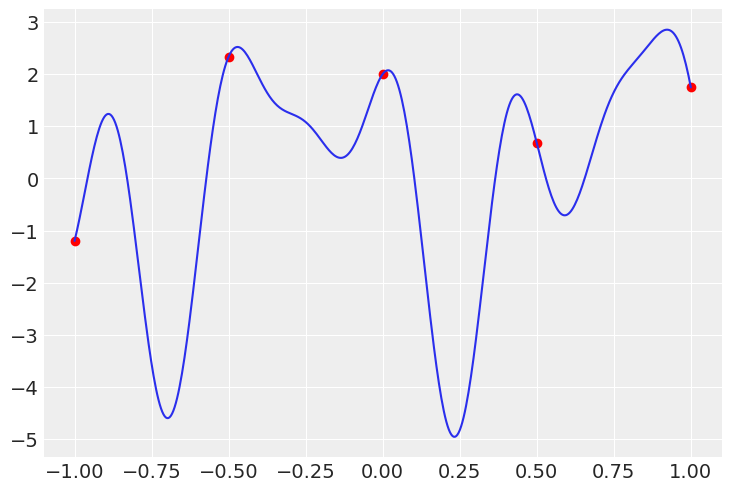

In [159]:
plt.plot(x_.numpy(), y_.numpy())
plt.scatter(x, y, color='red')


/var/folders/j4/79pszr2s63x4pyfdwfp6509r0000gp/T/ipykernel_9242/3445400308.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))
Sample: 100%|██████████| 1000/1000 [00:17, 58.10it/s, step size=4.36e-01, acc. prob=0.859]


array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

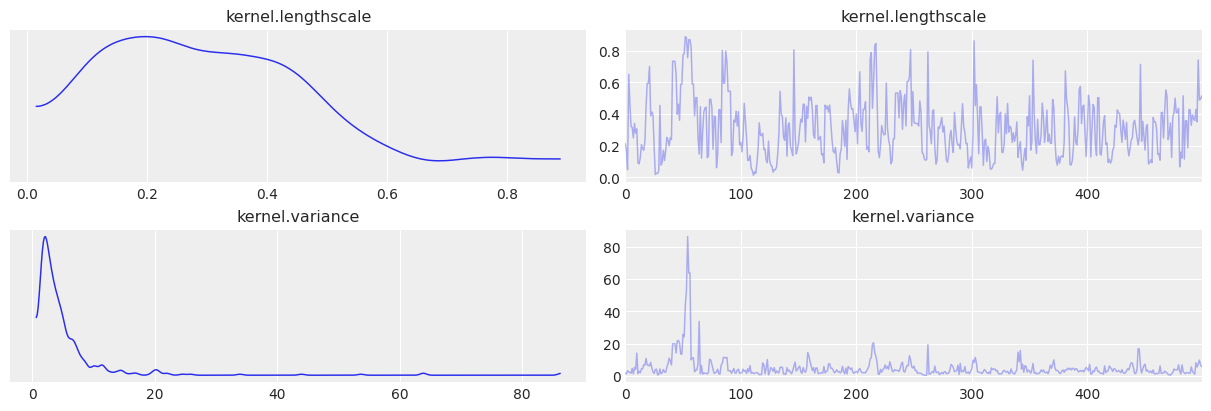

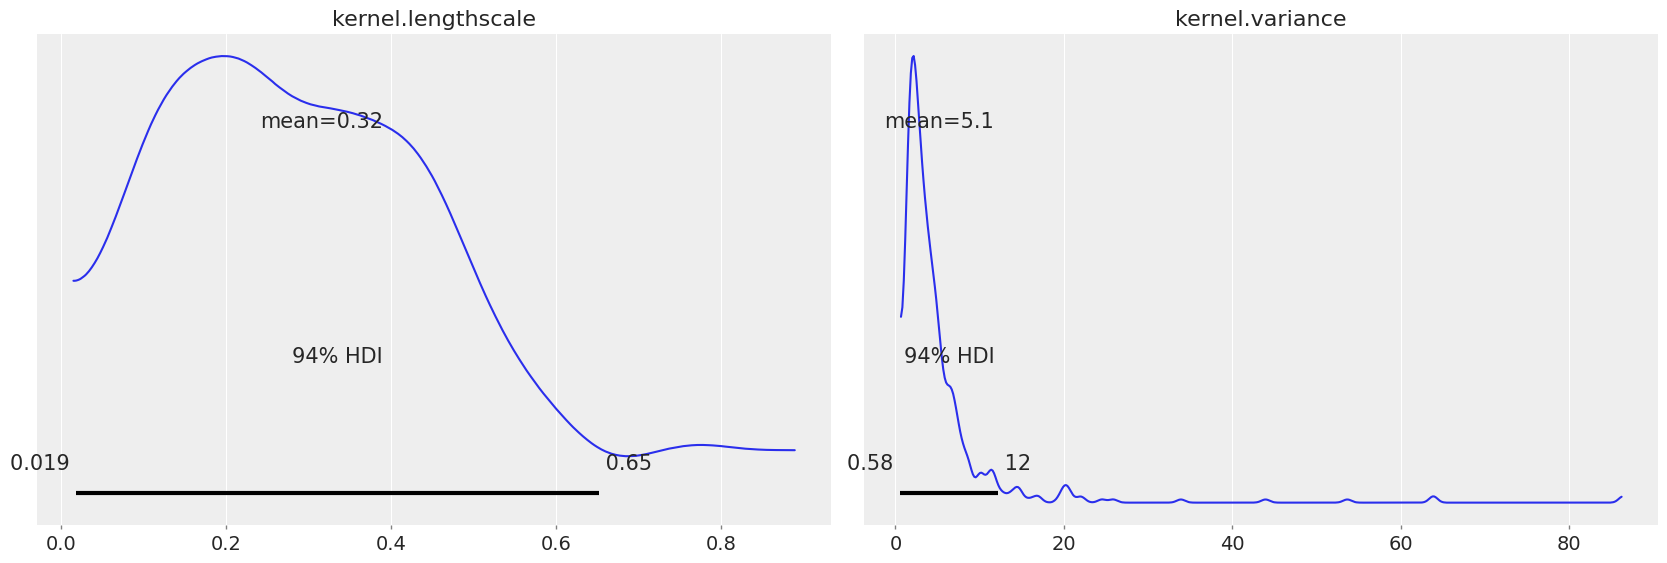

In [6]:
# trying with MCMCM
pyro.clear_param_store()

kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10.0)
)
gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-4)))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))

nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=500)
mcmc.run()

posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_var = mcmc.get_samples()['kernel.variance']

az.plot_trace(mcmc.get_samples(),compact=False)
az.plot_posterior(mcmc.get_samples())

tensor([0.0142, 0.0142, 0.0142, 0.0142, 0.0142])


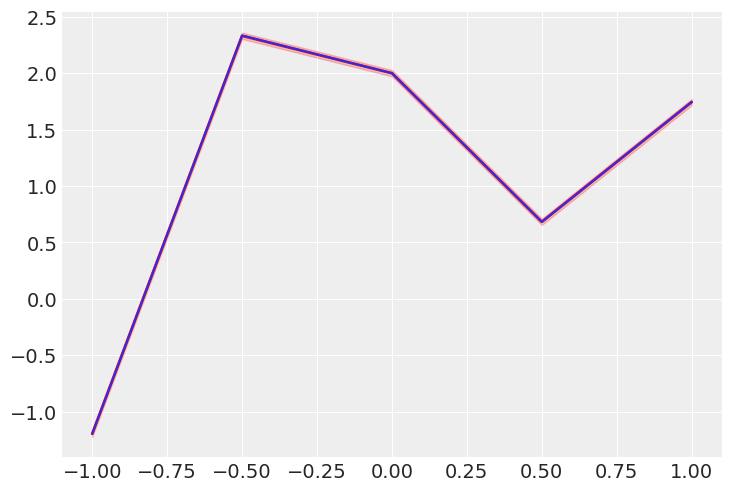

In [9]:
# compute predictive mean and variance
with torch.no_grad():
    mean, cov = gpr(x, full_cov=True, noiseless=False)

sd = cov.diag().sqrt()  # standard deviation at each input point x
plt.plot(x.numpy(), mean.numpy(), "r", lw=2)  # plot the mean
plt.fill_between(
    x,  # plot the two-sigma uncertainty about the mean
    (mean - 2.0 * sd).numpy(),
    (mean + 2.0 * sd).numpy(),
    color="r",
    alpha=0.2,
)
plt.plot(x, y)
print(sd)

# Assignment B

/var/folders/j4/79pszr2s63x4pyfdwfp6509r0000gp/T/ipykernel_9242/3947644463.py:7: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-2)))
Sample: 100%|██████████| 1000/1000 [00:17, 55.71it/s, step size=4.38e-01, acc. prob=0.830]


array([<AxesSubplot: title={'center': 'kernel.lengthscale'}>,
       <AxesSubplot: title={'center': 'kernel.variance'}>], dtype=object)

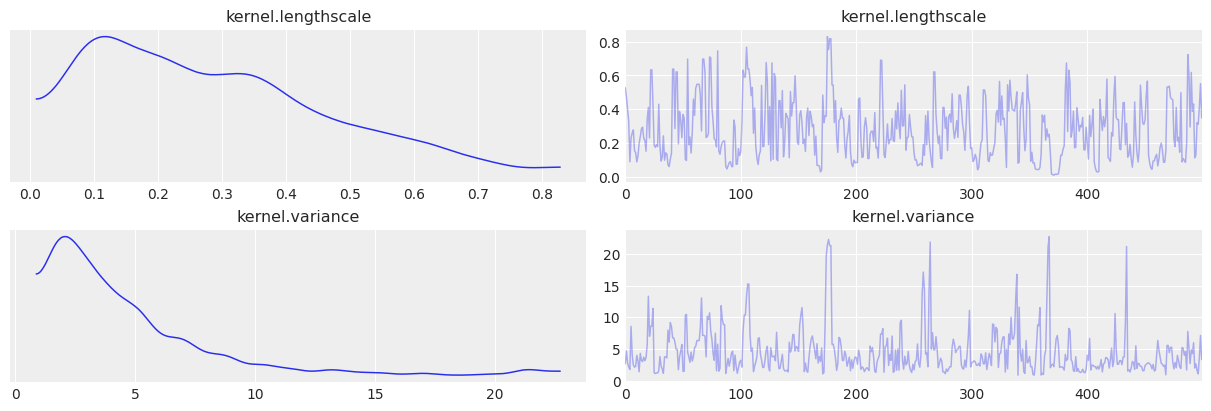

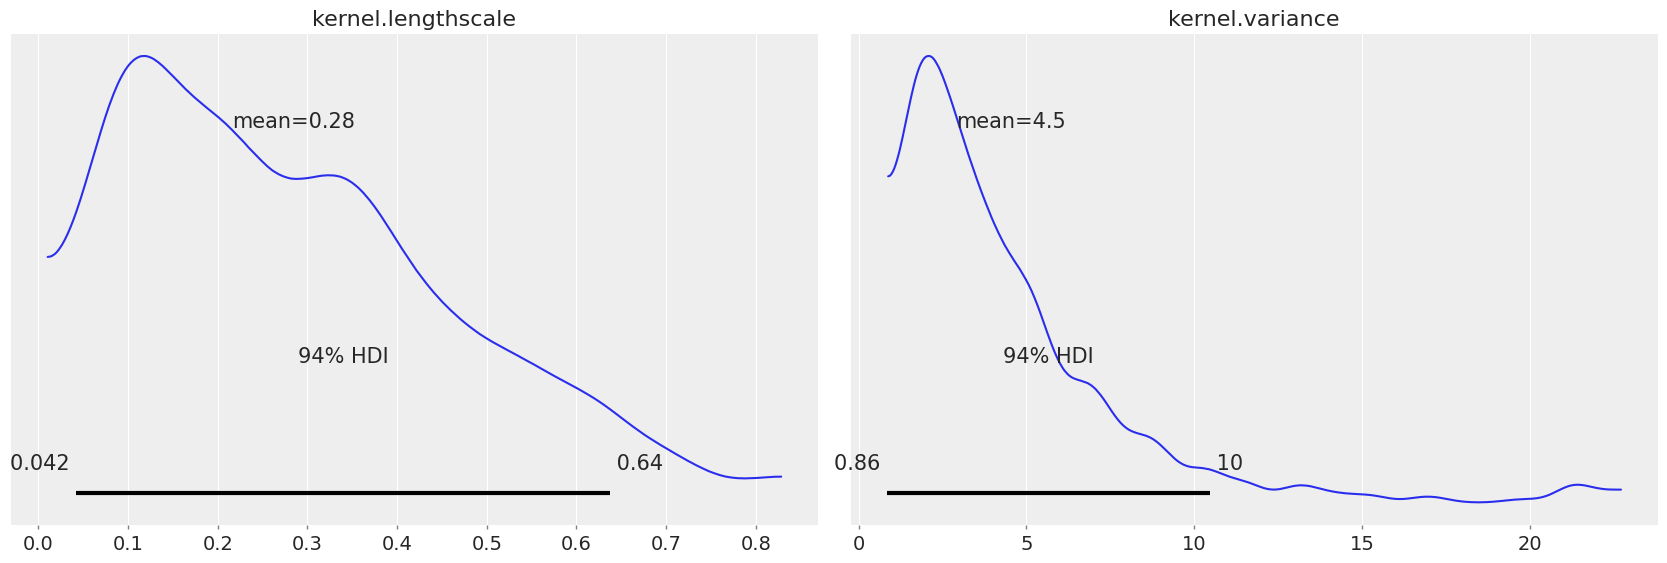

In [34]:
# trying with MCMCM
pyro.clear_param_store()

kernel = gp.kernels.RBF(
    input_dim=1, variance=torch.tensor(5.0), lengthscale=torch.tensor(10.0)
)
gpr = gp.models.GPRegression(torch.tensor(x), torch.tensor(y), kernel, noise=torch.tensor(10.0**(-2)))

# note that our priors have support on the positive reals
gpr.kernel.lengthscale = pyro.nn.PyroSample(dist.LogNormal(-1.0, 1.0))
gpr.kernel.variance = pyro.nn.PyroSample(dist.LogNormal(0.0, 2.0))

nuts_kernel = NUTS(gpr.model)
mcmc = MCMC(nuts_kernel, num_samples=500)
mcmc.run()

posterior_ls = mcmc.get_samples()["kernel.lengthscale"]
posterior_var = mcmc.get_samples()['kernel.variance']

az.plot_trace(mcmc.get_samples(),compact=False)
az.plot_posterior(mcmc.get_samples())

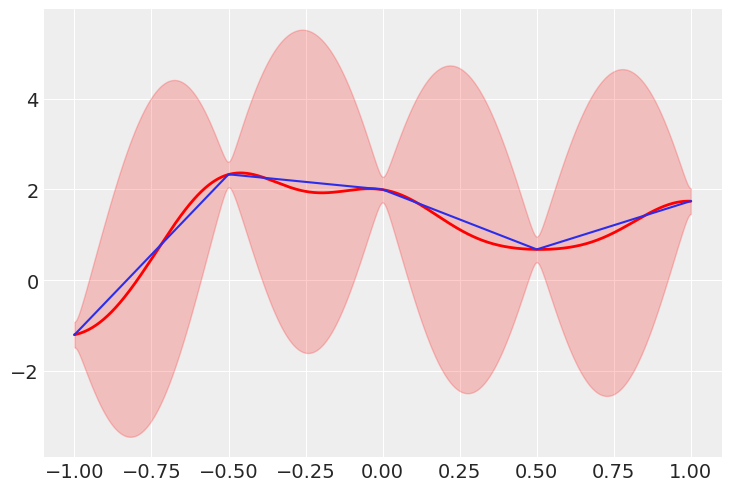

In [35]:
x_ = torch.linspace(-1, 1, 1000)
with torch.no_grad():
    m, cov = gpr(x_, full_cov=True, noiseless=False)

sd = cov.diag().sqrt()  # standard deviation at each input point x
plt.plot(x_.numpy(), m.numpy(), "r", lw=2)  # plot the mean
plt.fill_between(
    x_,  # plot the two-sigma uncertainty about the mean
    (m - 2.0 * sd).numpy(),
    (m + 2.0 * sd).numpy(),
    color="r",
    alpha=0.2,
)
plt.plot(x, y)


In [8]:
x_i, y_i = m.argmin(), m.min()
x_, y_ = torch.clone(x).detach(), torch.clone(y).detach()


x_ = torch.cat((x_, x_i.expand(1)), dim=0)
y_ = torch.cat((y_, y_i.expand(1)), dim=0)

NameError: name 'm' is not defined

In [44]:
m, v = gpr(torch.linspace(-1.0, 1.0, 1000), full_cov=True, noiseless=False)

In [64]:
xx = torch.linspace(-1, 1, 100)
ms = torch.tensor([])
for x_i in xx:
    m, _ = gpr(x_i.expand(1), full_cov=True, noiseless=False)
    m.backward()
    m.retain_grad()
    ms = torch.cat((ms, m.grad.expand(1)), dim=0)

y, _ = gpr(xx, full_cov=True, noiseless=False)

with torch.no_grad():
    plt.plot(xx, ms)
    plt.plot(xx, y)


AttributeError: 'NoneType' object has no attribute 'expand'

In [65]:
m, _ = gpr(x_i.expand(1), full_cov=True, noiseless=False)
m.backward()
m.retain_grad()

In [105]:
def fs(x):
    x_ = torch.tensor([x])
    with torch.no_grad():
        m, cov = gpr(x_, full_cov=True, noiseless=False)

    res = m.detach().numpy().astype(np.float64)[0] #clumsy
    return res

scipy.optimize.minimize_scalar(fs, bounds=(-10.0, 10.0), method="bounded")

RuntimeError: expected scalar type Float but found Double

In [181]:
def two_step_optimization(model, grid_size: 1000, n_iter=4, interval_frac=0.2, bounds=(-1.0, 1.0)):
    
    x_left, x_right = bounds[0], bounds[1]
    for i in range(n_iter):
        ls = torch.linspace(x_left, x_right, grid_size)

        with torch.no_grad():

            m, _ = model(ls, full_cov=True, noiseless=False)
            
            x0 = ls[m.argmin()]

            interval = torch.abs(torch.tensor(x_left) - torch.tensor(x_right))
        
        x_left = torch.tensor(x0) - interval*torch.tensor(interval_frac)
        x_right = torch.tensor(x0) + interval*torch.tensor(interval_frac)

    with torch.no_grad():
        m, _ = model(x0.expand(1), full_cov=True, noiseless=False)
        return x0, m[0]

two_step_optimization(gpr, grid_size = 1000, bounds=(0.0, 0.8))

    

/var/folders/j4/79pszr2s63x4pyfdwfp6509r0000gp/T/ipykernel_9242/4142237306.py:15: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_left = torch.tensor(x0) - interval*torch.tensor(interval_frac)
/var/folders/j4/79pszr2s63x4pyfdwfp6509r0000gp/T/ipykernel_9242/4142237306.py:16: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  x_right = torch.tensor(x0) + interval*torch.tensor(interval_frac)
/var/folders/j4/79pszr2s63x4pyfdwfp6509r0000gp/T/ipykernel_9242/4142237306.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  interval = torch.abs(torch.te

(tensor(0.5091), tensor(0.6802))

In [142]:
torch.clip(torch.tensor(0.0), min=torch.tensor(1.9), max = torch.tensor(12.0))

tensor(1.9000)

In [ ]:
# compute predictive mean and variance

def f_star(x):
    with torch.no_grad():
        x = torch.tensor([x], dtype=torch.float32)
        print(x)
        mean, _ = gpr(x, full_cov=True, noiseless=False)
    
    return mean.numpy()

res = scipy.optimize.minimize_scalar(f_star, bounds=(-1.0, 1.0), method='bounded')
res

for i in range()

#f_star(0.4)